## <font color='darkblue'> Reading image files </font>

In [1]:
import cv2
import glob
from joblib import dump, load
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pathlib 
import os
import random
import seaborn as sns


from PIL import Image
from skimage.feature import hog 
from sklearn.decomposition import PCA 
from sklearn.svm import SVC 
from zipfile import ZipFile                                     
from sklearn.metrics import accuracy_score

In [2]:
current_dir = os.getcwd().replace("\\","/")
data_directory = current_dir+'/data'

try: ## vérifier si un dossier data existe déjà (sinon, le créer) et le prendre comme répertoire courant afin d'y faire les téléchargements
    os.makedirs(data_directory) ##former le dossier data
    os.chdir(data_directory)
except :
    os.chdir(data_directory) 

##le code précédent va créer un répertoire data dans le répertoire current_dir grâce au chemin data_directory. Si on ne veut pas cela on peut créer le dossier data dans le répertoire parent en procédant comme suit:
#parent_directory = current_dir.replace('/'+os.path.basename(current_dir),"") ##former le dossier parent
#os.chdir(parent_directory)
#data_directory = parent_directory+'/data'
##puis exécuter le bloc try ...

##téléchargement
!curl -O https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!curl -O https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!curl -O https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

##dézipper
from zipfile import ZipFile

with ZipFile('GTSRB_Final_Training_Images.zip', 'r') as dezip:
    dezip.extractall('GTSRB_Final_Training_Images')
    
with ZipFile('GTSRB_Final_Test_Images.zip', 'r') as dezip:
    dezip.extractall('GTSRB_Final_Test_Images')
    
with ZipFile('GTSRB_Final_Test_GT.zip', 'r') as dezip:
    dezip.extractall('GTSRB_Final_Test_GT')

os.chdir(current_dir) ##retouner au précedent repertoire courant

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  263M    0 98304    0     0   159k      0  0:28:09 --:--:--  0:28:09  159k
  1  263M    1 2928k    0     0  1833k      0  0:02:27  0:00:01  0:02:26 1833k
  2  263M    2 7312k    0     0  2816k      0  0:01:35  0:00:02  0:01:33 2816k
  4  263M    4 12.0M    0     0  3427k      0  0:01:18  0:00:03  0:01:15 3426k
  6  263M    6 17.8M    0     0  3933k      0  0:01:08  0:00:04  0:01:04 3933k
  9  263M    9 24.0M    0     0  4390k      0  0:01:01  0:00:05  0:00:56 4899k
 10  263M   10 28.5M    0     0  4424k      0  0:01:00  0:00:06  0:00:54 5251k
 12  263M   12 33.1M    0     0  4459k      0  0:01:00  0:00:07  0:00:53 5309k
 14  263M   14 37.7M    0     0  4493k      0  0:01:00  0:00:08  0:00:52 5262k
 16  263M   16 42.5M    0     0  4529k      0  0:00

In [2]:
os.getcwd()

'C:\\Users\\jeane\\Documents\\new-hands-on-2021\\notebooks'

In [2]:
TRAINING_CSV_PATH = './data/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/*/*.csv'

IMAGE_WIDTH = 30
IMAGE_HEIGHT = IMAGE_WIDTH

In [4]:
os.path.dirname(TRAINING_CSV_PATH)

'./data/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/*'

In [3]:
def build_images_database(path):
    """Build a pandas DataFrame with all images information.
    
    Parameters
    ----------
    path: path pattern to read csv files containing images information
    
    Returns
    -------
    A pandas DataFrame with one line per image
    """
    df_list = []
    for filename in glob.glob(path):
        df = pd.read_csv(filename, sep=';')
        df['path'] = os.path.dirname(filename) + '/' + df['Filename']
        df_list.append(df)
    
    return pd.concat(df_list, ignore_index=True)


def build_images_list(filename_list, boxes_list=None,model ="cnn"):
    """Build a list of images as Numpy array if model = "cnn"
    If model = "svm". In this case, the function build a Numpy array by extracting features with Histogram of oriented gradients (HOG).
    Firstly, HOG computes the gradient image in x and y for pixel, then computes gradient histograms and normalize 
    across blocks, finally it flattens into a feature vector.
    
    
    Parameters
    ----------
    filename_list: list of images filenames
    boxes_list: optional list of boxes for clipping within images. Boxes are 4-tuples (x1, y1, x2, y2).
    model: model for which the data is going to be build.
    
    Returns
    -------
    images_list: A list of images as Numpy arrays
    Features : Numpy array, where each line is the set of features of the corresponding image
    
    """
    
    # If no boxes_list is given, generate a fake boxes list with None boxes
    # image.resize will take full size images if argument box == None
    if boxes_list is None:
        boxes_list = [None] * len(filename_list)
        
    assert len(filename_list) == len(boxes_list), "filenames and boxes lists must have the same length"
    
    if model == 'cnn': 
        images_list = []
        for (filename, image_box) in zip(filename_list, boxes_list):
            image = Image.open(filename)
            image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
            image = np.array(image)
            images_list.append(image)

        return images_list
    
    elif model == 'svm': 
        ##if model is svm : flatten the images in order to have information about the color, then apply HOG to the image
        Features = []
        for (filename, image_box) in zip(filename_list, boxes_list):
            image = Image.open(filename)
            image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
            image_flat = np.asarray(image).flatten().tolist()
            image = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2GRAY) ##convert to grayscale 

            # Apply Hog from skimage library it takes image a grayscale image. Number of orientation bins that gradient
            # need to calculate. Apply the thresholding: For every pixel, the same threshold value is applied. 
            #If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value
            ret,thresh_image = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
            descriptor = hog(thresh_image, orientations=8,pixels_per_cell=(4,4)).tolist()
            image_flat.extend(descriptor) #adding hog features
            Features.append(image_flat)

        Features=np.array(Features)
        return Features

    
def build_classes_array(df, col_name='ClassId'):
    """Build a vector (numpy array) of classes
    
    Parameters
    ----------
    df: pandas DataFrame with a column containing classes id
    
    Returns
    -------
    Numpy array with image classes
    
    """
    return df[col_name].values


In [4]:
images_df = build_images_database(TRAINING_CSV_PATH)
images_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,29,30,5,6,24,25,0,./data/GTSRB_Final_Training_Images/GTSRB/Final...
1,00000_00001.ppm,30,30,5,5,25,25,0,./data/GTSRB_Final_Training_Images/GTSRB/Final...
2,00000_00002.ppm,30,30,5,5,25,25,0,./data/GTSRB_Final_Training_Images/GTSRB/Final...
3,00000_00003.ppm,31,31,5,5,26,26,0,./data/GTSRB_Final_Training_Images/GTSRB/Final...
4,00000_00004.ppm,30,32,5,6,25,26,0,./data/GTSRB_Final_Training_Images/GTSRB/Final...


In [5]:
# Reading only 200 images for the moment
images_list = build_images_list(images_df.head(200)['path'].values,
                                images_df.head(200).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                          axis=1).values,model ="cnn")

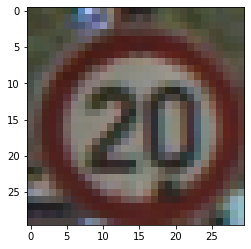

In [43]:
plt.imshow(images_list[190])

In [6]:
build_classes_array(images_df)

array([ 0,  0,  0, ..., 42, 42, 42], dtype=int64)

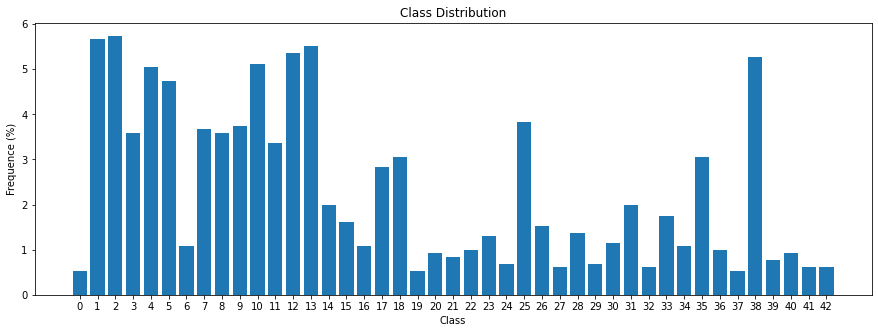

In [7]:
plt.figure(figsize=(15,5))
plt.bar(images_df['ClassId'].value_counts().index.tolist(),images_df['ClassId'].value_counts(normalize = True)*100)

CLASS_COUNT = len(images_df['ClassId'].value_counts())
plt.xticks(range(CLASS_COUNT),range(CLASS_COUNT))
plt.title("Class Distribution")
plt.xlabel('Class')
plt.ylabel('Frequence (%)')
plt.show()

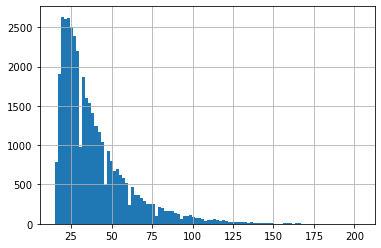

In [8]:
(images_df['Roi.X2'] - images_df['Roi.X1']).hist(bins=100);

In [9]:
(images_df['Roi.Y2'] - images_df['Roi.Y1']).median()

32.0

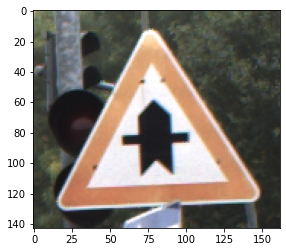

In [10]:
plt.imshow(Image.open(images_df.query('Width == 162')['path'].values[0]))

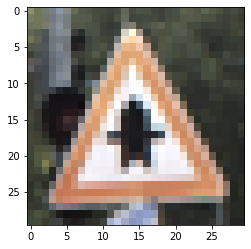

In [11]:
plt.imshow(Image.open(images_df.query('Width == 162')['path'].values[0]).resize((30, 30)))

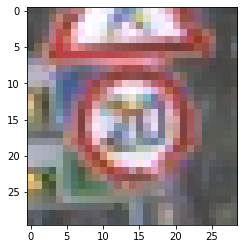

In [12]:
plt.imshow(Image.open('./data/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00000/00000_00000.ppm'))##sur colab

In [13]:
images_df.head(1)

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,29,30,5,6,24,25,0,./data/GTSRB_Final_Training_Images/GTSRB/Final...


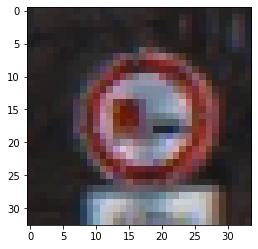

In [14]:
plt.imshow(Image.open('./data/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00010/00029_00010.ppm'))

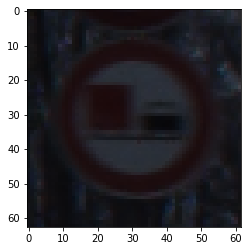

In [15]:
plt.imshow(Image.open('./data/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00010/00005_00029.ppm'))

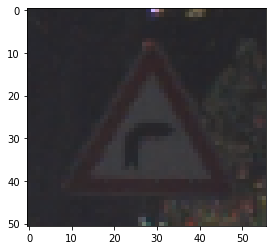

In [16]:
plt.imshow(Image.open(images_df.query('ClassId == 20').iloc[20]['path']))

## <font color='darkblue'>Training the models </font>

### <font color='darkblue'>1- Convolutional Neural Network </font>

In [18]:
import tensorflow as tf

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [19]:
images_df.shape

(39209, 9)

In [20]:
images_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,29,30,5,6,24,25,0,./data/GTSRB_Final_Training_Images/GTSRB/Final...
1,00000_00001.ppm,30,30,5,5,25,25,0,./data/GTSRB_Final_Training_Images/GTSRB/Final...
2,00000_00002.ppm,30,30,5,5,25,25,0,./data/GTSRB_Final_Training_Images/GTSRB/Final...
3,00000_00003.ppm,31,31,5,5,26,26,0,./data/GTSRB_Final_Training_Images/GTSRB/Final...
4,00000_00004.ppm,30,32,5,6,25,26,0,./data/GTSRB_Final_Training_Images/GTSRB/Final...


### <font color='darkblue'>a- Model sans tpu, exécution avec 10000 observations

In [21]:
def data_for_the_model(n = None,model="cnn"):
    
    """Select the data for the training a test
    
    Parameters
    ----------
    n: Number of observation to take into account
    model: model for which the data while be constructed
    
    Returns
    -------
    data : A list of images as Numpy arrays
    labels : label of each image
    """
    
    if n is None:
        
      images_list = build_images_list(images_df['path'].values,
                                  images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                            axis=1).values,model = model)
      data = np.array(images_list)
      labels = build_classes_array(images_df)
    
    else:
      images_list = build_images_list(images_df.head(n)['path'].values,
                                      images_df.head(n).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                                axis=1).values,model = model)
      data = np.array(images_list)
      labels = build_classes_array(images_df)[:n]
    
    return data, labels

In [22]:
data, labels = data_for_the_model(n = 10000,model="cnn")

In [23]:
print(data.shape, labels.shape)

(10000, 30, 30, 3) (10000,)


In [24]:
#Splitting training and testing dataset
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_train_1.shape, X_test_1.shape, y_train_1.shape, y_test_1.shape)

(8000, 30, 30, 3) (2000, 30, 30, 3) (8000,) (2000,)


In [34]:
#Converting the labels into one hot encoding
y_train_onehot_1 = to_categorical(y_train_1, 43)
y_test_onehot_1 = to_categorical(y_test_1, 43)


In [35]:
#Building the model
model_1 = Sequential()
model_1.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train_1.shape[1:]))
model_1.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model_1.add(MaxPool2D(pool_size=(2, 2)))
model_1.add(Dropout(rate=0.25))
model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_1.add(MaxPool2D(pool_size=(2, 2)))
model_1.add(Dropout(rate=0.25))
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(rate=0.5))
model_1.add(Dense(43, activation='softmax'))

#Compilation of the model
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
%%time
epochs = 15
history_1 = model_1.fit(X_train_1, y_train_onehot_1, batch_size=32, epochs=epochs, validation_data=(X_test_1, y_test_onehot_1))

Epoch 1/15
250/250 [==============================] - 19s 78ms/step - loss: 1.7872 - accuracy: 0.5824 - val_loss: 0.2921 - val_accuracy: 0.9435
Epoch 2/15
250/250 [==============================] - 25s 101ms/step - loss: 0.4374 - accuracy: 0.8730 - val_loss: 0.1052 - val_accuracy: 0.9775
Epoch 3/15
250/250 [==============================] - 31s 124ms/step - loss: 0.2786 - accuracy: 0.9190 - val_loss: 0.0878 - val_accuracy: 0.9755
Epoch 4/15
250/250 [==============================] - 31s 123ms/step - loss: 0.1849 - accuracy: 0.9465 - val_loss: 0.0909 - val_accuracy: 0.9790
Epoch 5/15
250/250 [==============================] - 32s 128ms/step - loss: 0.1909 - accuracy: 0.9463 - val_loss: 0.0489 - val_accuracy: 0.9890
Epoch 6/15
250/250 [==============================] - 31s 124ms/step - loss: 0.1638 - accuracy: 0.9499 - val_loss: 0.0727 - val_accuracy: 0.9800
Epoch 7/15
250/250 [==============================] - 31s 124ms/step - loss: 0.1431 - accuracy: 0.9591 - val_loss: 0.0469 - val_acc

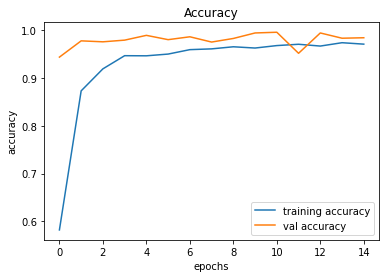

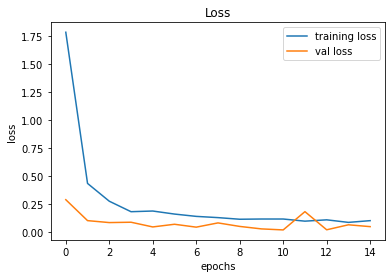

In [37]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history_1.history['accuracy'], label='training accuracy')
plt.plot(history_1.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history_1.history['loss'], label='training loss')
plt.plot(history_1.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [25]:
def classify_image(path, model, image_box=None): 
    """Classify image by model

    Parameters
    ----------
    path: filepath to image
    model: tf/keras classifier

    Returns
    -------
    A dictionary that contains: class id returned by model classifier; the probability of that class, and the probability of the class
    """
    images_list = []
    image = Image.open(path)
    image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
    image = np.array(image)
    images_list.append(image)
    predictions = model.predict(np.array(images_list))
    dico = {'id_class_pred':np.argmax(predictions),'prob_class_pred':round(np.max(predictions),2),'prob_all_class':predictions.tolist()}
    return dico

In [38]:
# Tirage aléatoire d'une image
image_sample = images_df.sample(1)
print('id of class predicted :')
classify_image(image_sample['path'].values[0],
               model_1,
               image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                  axis=1).values[0]
              )['id_class_pred']

id of class predicted :


35

### <font color='darkblue'>b- model avec tpu, exécution avec toutes les observations

In [39]:
data_2, labels_2 = data_for_the_model(n=None,model="cnn")
print(data_2.shape, labels_2.shape)

(39209, 30, 30, 3) (39209,)


In [40]:
#Splitting training and testing dataset
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data_2, labels_2, test_size=0.2, random_state=42)

print(X_train_2.shape, X_test_2.shape, y_train_2.shape, y_test_2.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [41]:
#Converting the labels into one hot encoding
y_train_onehot_2 = to_categorical(y_train_2, 43)
y_test_onehot_2 = to_categorical(y_test_2, 43)

print(y_train_onehot_2.shape,y_test_onehot_2.shape)

(31367, 43) (7842, 43)


In [42]:
# Connexion vers une TPU Google

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.113.128.106:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.113.128.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.113.128.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [43]:
# Recompilation du modèle

with tpu_strategy.scope():
  model_2 = Sequential()
  model_2.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train_2.shape[1:]))
  model_2.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
  model_2.add(MaxPool2D(pool_size=(2, 2)))
  model_2.add(Dropout(rate=0.25))
  model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model_2.add(MaxPool2D(pool_size=(2, 2)))
  model_2.add(Dropout(rate=0.25))
  model_2.add(Flatten()) 
  model_2.add(Dense(256, activation='relu'))
  model_2.add(Dropout(rate=0.5))
  model_2.add(Dense(43, activation='softmax'))
  model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        2432      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)         

In [44]:
%%time
epochs = 15
history_2 = model_2.fit(X_train_2, y_train_onehot_2, batch_size=32, epochs=epochs, validation_data=(X_test_2, y_test_onehot_2))

Epoch 1/15
981/981 [==============================] - 29s 25ms/step - loss: 2.7717 - accuracy: 0.4136 - val_loss: 0.2375 - val_accuracy: 0.9463
Epoch 2/15
981/981 [==============================] - 21s 22ms/step - loss: 0.4294 - accuracy: 0.8830 - val_loss: 0.1157 - val_accuracy: 0.9736
Epoch 3/15
981/981 [==============================] - 21s 21ms/step - loss: 0.2901 - accuracy: 0.9210 - val_loss: 0.0780 - val_accuracy: 0.9804
Epoch 4/15
981/981 [==============================] - 21s 21ms/step - loss: 0.2122 - accuracy: 0.9427 - val_loss: 0.0510 - val_accuracy: 0.9869
Epoch 5/15
981/981 [==============================] - 21s 21ms/step - loss: 0.1796 - accuracy: 0.9525 - val_loss: 0.0635 - val_accuracy: 0.9846
Epoch 6/15
981/981 [==============================] - 21s 21ms/step - loss: 0.1479 - accuracy: 0.9607 - val_loss: 0.0556 - val_accuracy: 0.9870
Epoch 7/15
981/981 [==============================] - 21s 21ms/step - loss: 0.1745 - accuracy: 0.9582 - val_loss: 0.0428 - val_accuracy:

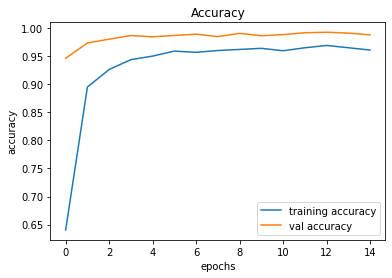

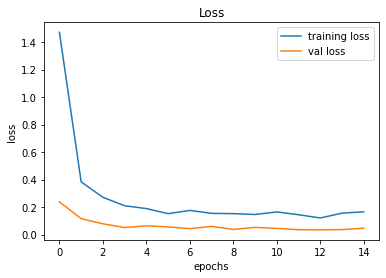

In [45]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history_2.history['accuracy'], label='training accuracy')
plt.plot(history_2.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history_2.history['loss'], label='training loss')
plt.plot(history_2.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [22]:
import datetime
def save_classifier(model, basename):
  """Save to H5 format a TF model with a timestamp

  Paramaters
  ----------
  model: trained tf model
  basename: basename including path to use for filename. Note that if you are not using colab, you could need 
  to create the directory, before giving its basename.
  
  Returns
  -------
  name : path to the model
  """
  name = '{}_{}.h5'.format(basename, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
  model.save(name)
  return name

In [47]:
save_name_2 = save_classifier(model_2, 'models/traffic_signs') ## save into models/traffic_signs in colab for ex; 
#save= save_classifier(model_2, './') # to save in the cwd

In [40]:
save= save_classifier(model_1, './') # to save in the cwd

In [42]:
save

'./_2021-04-11_13-35-22.h5'

In [43]:
mod = load_model(save)

In [52]:
# Tirage aléatoire d'une image
image_sample = images_df.sample(1)
print('id of class predicted :')
dfff = classify_image(image_sample['path'].values[0],
               mod,
               image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                  axis=1).values[0]
               )['id_class_pred']

id of class predicted :


ne pas oublier de télécharger le modèle sauvegardé, pour cela créer un dossier models dans le dossier github qui est sur l'ordinateur et y mettre le modèle

**Compare actual to predicted (class-level)**

In [48]:
# Tirage aléatoire d'une image
image_sample = images_df.sample(1)
print('id of class predicted :')
classify_image(image_sample['path'].values[0],
               model_2,
               image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                  axis=1).values[0]
               )['id_class_pred']

id of class predicted :


40

In [ ]:
image_sample = images_df.sample(1)
print('id of class predicted :')
classify_image(image_sample['path'].values[0],
               model_2,
               image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                  axis=1).values[0]
               )['id_class_pred']

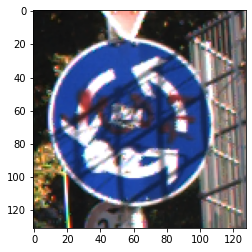

In [49]:
# Affichage de l'image
plt.imshow(Image.open(image_sample['path'].values[0]))

Reloading model

In [50]:
test_model_2 = load_model(save_name_2)

In [15]:
image_sample = images_df.sample(1)
print('id of class predicted :')
classify_image(image_sample['path'].values[0],
               test_model_2,
               image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                  axis=1).values[0]
               )['id_class_pred']

NameError: name 'images_df' is not defined

**Evaluating performance**

**Extracting data**

In [52]:
!ls data/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/*.csv

data/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/GT-final_test.test.csv


In [53]:
!head data/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/*.csv

Filename;Width;Height;Roi.X1;Roi.Y1;Roi.X2;Roi.Y2
00000.ppm;53;54;6;5;48;49
00001.ppm;42;45;5;5;36;40
00002.ppm;48;52;6;6;43;47
00003.ppm;27;29;5;5;22;24
00004.ppm;60;57;5;5;55;52
00005.ppm;52;56;5;5;47;51
00006.ppm;147;130;12;12;135;119
00007.ppm;32;33;5;5;26;28
00008.ppm;45;50;6;5;40;45


In [54]:
!head data/GTSRB_Final_Test_GT/GT-final_test.csv 

Filename;Width;Height;Roi.X1;Roi.Y1;Roi.X2;Roi.Y2;ClassId
00000.ppm;53;54;6;5;48;49;16
00001.ppm;42;45;5;5;36;40;1
00002.ppm;48;52;6;6;43;47;38
00003.ppm;27;29;5;5;22;24;33
00004.ppm;60;57;5;5;55;52;11
00005.ppm;52;56;5;5;47;51;38
00006.ppm;147;130;12;12;135;119;18
00007.ppm;32;33;5;5;26;28;12
00008.ppm;45;50;6;5;40;45;25


In [28]:
test_images_df = pd.read_csv('./data/GTSRB_Final_Test_GT/GT-final_test.csv', sep = ';')
test_images_df['path'] = test_images_df['path'] = test_images_df['Filename']\
    .apply(lambda x: './data/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/' +x)

test_images_df.tail()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
12625,12625.ppm,42,41,5,6,37,36,12,./data/GTSRB_Final_Test_Images/GTSRB/Final_Tes...
12626,12626.ppm,50,51,6,5,45,46,33,./data/GTSRB_Final_Test_Images/GTSRB/Final_Tes...
12627,12627.ppm,29,29,6,6,24,24,6,./data/GTSRB_Final_Test_Images/GTSRB/Final_Tes...
12628,12628.ppm,48,49,5,6,43,44,7,./data/GTSRB_Final_Test_Images/GTSRB/Final_Tes...
12629,12629.ppm,32,31,6,5,27,26,10,./data/GTSRB_Final_Test_Images/GTSRB/Final_Tes...


In [29]:
test_list = build_images_list(test_images_df['path'].values,
                              test_images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                   axis=1).values,model ="cnn")
test_data = np.array(test_list)
test_labels = build_classes_array(test_images_df)## les vrais labels

In [80]:
print(test_data.shape, test_labels.shape)

(12630, 30, 30, 3) (12630,)


In [58]:
%%time
results = np.argmax(test_model_2.predict(test_data),axis=1) ##le modèle stocké est utilisé pour la prédiction
results

CPU times: user 254 ms, sys: 96.3 ms, total: 350 ms
Wall time: 1.59 s


In [59]:
results[:3]

array([16,  1, 38])

In [60]:
(test_labels == results).sum() / test_labels.shape[0]

0.9530482977038797

**Compare actual to predict (class level)**

In [61]:
accuracy_df = pd.DataFrame()
accuracy_df['actual'] = test_labels
accuracy_df['predicted'] = results

In [62]:
pd.crosstab(accuracy_df['actual'],accuracy_df['predicted']).head(10)

predicted,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
actual,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,698,1,0,14,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,0,1,746,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,1,419,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
4,0,1,0,0,655,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
5,0,2,2,2,0,618,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0,0,1,0,0,0,0,0,0,0,0,0
6,0,3,0,0,1,9,121,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,1,1,4
7,0,1,0,0,1,4,0,442,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,5,1,3,3,16,0,4,410,0,0,0,1,0,1,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


Text(0.5, 1.0, 'CNN confusion matrix heatmap')

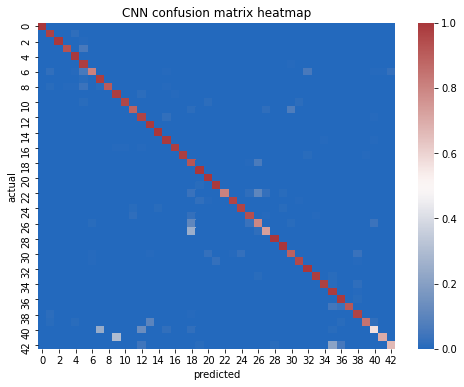

In [63]:
fig, ax =  plt.subplots(figsize=(8, 6))

sns.heatmap(pd.crosstab(accuracy_df['actual'],accuracy_df['predicted'], normalize='index'),
            cmap='vlag')
plt.title("CNN confusion matrix heatmap")
##1 indique qu'on a bien classifié i (ligne) ou que 100% des observation classés i (ligne) sont  bels et bien i (colone),cela est représenté par le rouge sur la diagonale
## le graphique donne en générale pour chaque ligne i qui est la classe prédite, le nombre d'élément
##qui devrait être normalement classé en classe colonne i.
##moins c'est rouge sur la diagonale, moins c'est bon. Le CNN semble plus se trompé à la classe 27

### <font color='darkblue'>2- SVM

As it can be seen in the build_image_liste function, we transform the images by :
 - flatten the input images in order to get the pixel into a 1-D array
 - Apply Histogram of Oriented Gradients
 - put together the flattened input and the result of the HOG

After that, we apply PCA for dimension reduction and then fit the SVM. 

In [26]:
# Generating HOG features for training set 
data_svm, labels_svm  = data_for_the_model(n=None,model="svm")
print(data_svm.shape,labels_svm.shape)

(39209, 4500) (39209,)


In [30]:
##data for testing 
test_list_svm = build_images_list(test_images_df['path'].values,
                              test_images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                   axis=1).values,model ="svm")

test_labels_svm = build_classes_array(test_images_df)## les vrais labels : pareille pour cnn; test_labels_svm=test_labels 

print(test_list_svm.shape, test_labels_svm.shape)

(12630, 4500) (12630,)


In [31]:
# Applying PCA
pca = PCA(n_components = 150) # we keep just the first 120 principal components
X_train_svm = pca.fit_transform(data_svm)
X_test_svm = pca.transform(test_list_svm)

print ('New Train Dataset shape after PCA: ',X_train_svm.shape)
print ('New Test Dataset shape after PCA: ',X_test_svm.shape)

New Train Dataset shape after PCA:  (39209, 150)
New Test Dataset shape after PCA:  (12630, 150)


Fit a default SVM with gamma = scale

In [32]:
%%time
# Fitting classifier to the Training set
classifier = SVC(kernel='rbf',gamma="scale") # Calling the function SVC to implement SVM
classifier.fit(X_train_svm,labels_svm) # Training the Classifier on Train date

Wall time: 1min 46s


SVC()

In [33]:
# get the accuracy train
predicted_train_svm = classifier.predict(X_train_svm)
acc_train = accuracy_score(labels_svm, predicted_train_svm)*100
print('SVM Accuracy of Train dataset: ',round(acc_train,2),'%')

SVM Accuracy of Train dataset:  94.58 %


In [44]:
# get the accuracy on the test 
predicted_test_svm = classifier.predict(X_test_svm)
score0 = accuracy_score(test_labels_svm, predicted_test_svm)*100
print('SVM Accuracy of Test dataset: ',round(score0,2),'%')

SVM Accuracy of Test dataset:  81.08 %


In [109]:
# save in the cwd
dump(classifier, 'new_svm.joblib')
dump(pca, 'pca.joblib')

['pca.joblib']

In [71]:
svm = load('svm.joblib') 
pca = load('pca.joblib') 

In [72]:
new_x_test = pca.transform(test_list_svm)

In [73]:
new_pred = svm.predict(new_x_test)

Text(0.5, 1.0, 'SVM confusion matrix heatmap')

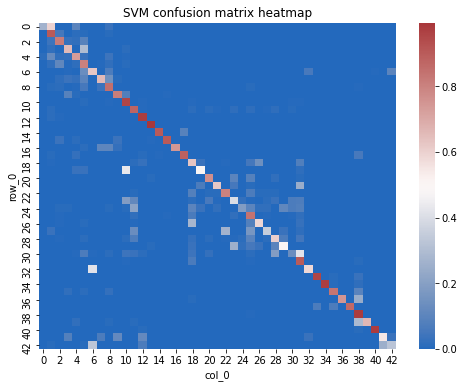

In [74]:
fig, ax =  plt.subplots(figsize=(8, 6))

sns.heatmap(pd.crosstab(test_labels_svm,new_pred, normalize='index'),cmap='vlag')
plt.title("SVM confusion matrix heatmap")

In [35]:
%%time
# tune parameters by training and testing 12 SVMs on test set, each with different C and gamma parameters. One could use a validtion set
#here, we skeep this.
C_grid = [1, 10, 100]
g_grid = ["scale",'auto', .01, .1]

##Initialisation
best_C = 1
best_g = 'scale'
best_score = score0

for C in C_grid:
    for g in g_grid:
        svc = SVC(kernel='rbf',C=C, gamma=g, random_state=4)
        svc.fit(X_train_svm, labels_svm)
        y_pred = svc.predict(X_test_svm)
        score = accuracy_score(test_labels_svm, y_pred)
        print('C: {}'.format(C))
        print('gamma: {}'.format(g))
        print('accuracy score: {}'.format(score))
        print()
        if score > best_score:
            best_C = C
            best_g = g
            best_score = score

print(f"Best C: {best_C}")
print(f"Best gamma: {best_g}")
print(f"Best accuracy score: {best_score}")

C: 1
gamma: scale
accuracy score: 0.8108471892319873

C: 1
gamma: auto
accuracy score: 0.06001583531274743

C: 1
gamma: 0.01
accuracy score: 0.059936658749010295

C: 1
gamma: 0.1
accuracy score: 0.05946159936658749

C: 10
gamma: scale
accuracy score: 0.8517814726840855

C: 10
gamma: auto
accuracy score: 0.06001583531274743

C: 10
gamma: 0.01
accuracy score: 0.06001583531274743

C: 10
gamma: 0.1
accuracy score: 0.05954077593032463

C: 100
gamma: scale
accuracy score: 0.8501979414093428

C: 100
gamma: auto
accuracy score: 0.06001583531274743

C: 100
gamma: 0.01
accuracy score: 0.06001583531274743

C: 100
gamma: 0.1
accuracy score: 0.05954077593032463

Best C: 1
Best gamma: scale
Best accuracy score: 81.08471892319872
Wall time: 2h 48min 30s


In [46]:
# Re-Fitting the best classifier to the Training set
new_classifier = SVC(kernel='rbf',gamma="scale",C=10) # Calling the function SVC to implement SVM
new_classifier.fit(X_train_svm,labels_svm) # Training the Classifier on Train date

SVC(C=10)

In [47]:
# get the accuracy on the test 
new_predicted_test_svm = new_classifier.predict(X_test_svm)
acc_test = accuracy_score(test_labels_svm, predicted_test_svm)*100
print('SVM Accuracy of Test dataset: ',round(acc_test,2),'%')

SVM Accuracy of Test dataset:  81.08 %


Text(0.5, 1.0, 'SVM confusion matrix heatmap')

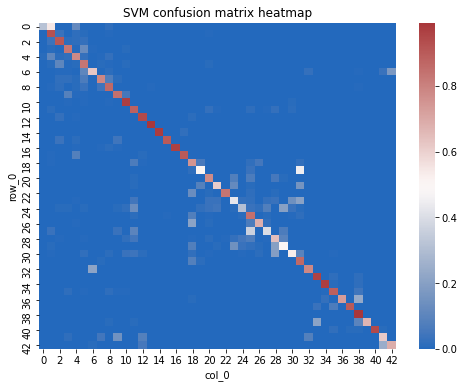

In [49]:
fig, ax =  plt.subplots(figsize=(8, 6))

sns.heatmap(pd.crosstab(test_labels_svm,new_predicted_test_svm, normalize='index'),cmap='vlag')
plt.title("SVM confusion matrix heatmap")

In [50]:
# save the best model in the cwd
dump(new_classifier, '../models/new_svm.joblib')
dump(pca, '../models/pca.joblib')

['../models/pca.joblib']

In [51]:
momo = load("C:/Users/jeane/Documents/new-hands-on-2021/models/new_svm.joblib")
mopc = load("C:/Users/jeane/Documents/new-hands-on-2021/models/pca.joblib")

In [52]:
image_sample = images_df.sample(1)
trsz = build_images_list(image_sample['path'].values,
                              image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                   axis = 1).values,model ="svm")

In [53]:
trsz.shape

(1, 4500)

In [54]:
reduct = mopc.transform(trsz)
momo.predict(reduct).item()

12

In [55]:
decision = momo.decision_function(reduct) # decision is a voting function
prob = np.exp(decision)/np.sum(np.exp(decision),axis=1, keepdims=True) # softmax after the voting
prob

array([[2.58935018e-19, 2.83517178e-11, 2.88736112e-04, 2.61053501e-07,
        1.29195895e-08, 3.90323530e-05, 5.78406667e-03, 3.89863901e-05,
        2.62598829e-07, 1.29027030e-08, 3.90429772e-05, 3.88891533e-05,
        8.66884080e-01, 4.71219029e-09, 5.19930456e-18, 5.73421912e-15,
        7.42319491e-11, 1.41173270e-17, 2.13146123e-03, 1.90676639e-18,
        1.72577420e-09, 6.29077175e-10, 7.02860891e-19, 8.67416344e-13,
        8.61946093e-13, 1.28814862e-08, 1.39281102e-10, 2.10731642e-15,
        2.83984042e-16, 7.73838886e-16, 5.79183739e-03, 1.56280345e-14,
        5.18617187e-06, 4.27282514e-14, 1.04793843e-16, 2.57547497e-07,
        4.63914877e-09, 9.31693619e-13, 2.59787030e-07, 3.85904674e-17,
        2.13322055e-03, 1.16538566e-01, 2.85803014e-04]])

In [56]:
prob.tolist()[0]

[2.589350178076306e-19,
 2.8351717831153794e-11,
 0.00028873611221402285,
 2.610535011862851e-07,
 1.291958946421217e-08,
 3.90323529597561e-05,
 0.005784066666848585,
 3.8986390141337025e-05,
 2.625988288710668e-07,
 1.290270295711092e-08,
 3.904297718840773e-05,
 3.888915332878422e-05,
 0.8668840803652803,
 4.712190287609114e-09,
 5.199304555381557e-18,
 5.7342191172403654e-15,
 7.423194907902849e-11,
 1.4117327047653977e-17,
 0.0021314612258972803,
 1.9067663914871923e-18,
 1.7257742014424967e-09,
 6.290771745762636e-10,
 7.028608906836942e-19,
 8.674163436533526e-13,
 8.619460927447676e-13,
 1.2881486169874313e-08,
 1.39281101997237e-10,
 2.1073164192695522e-15,
 2.8398404218201337e-16,
 7.738388862586766e-16,
 0.005791837389353354,
 1.5628034461627303e-14,
 5.186171873441456e-06,
 4.272825138603216e-14,
 1.0479384284573468e-16,
 2.575474967315624e-07,
 4.639148765927057e-09,
 9.316936186742743e-13,
 2.5978703030664615e-07,
 3.8590467409063915e-17,
 0.0021332205464878796,
 0.116538

In [58]:
def pertub_image(image, n_pixel, seed = None):
    """Create a pertubation in the image by changing a given number of pixels value at random positions.
    
    Parameters
    ----------
    image: numpy array of the original image
    
    n_pixel: number of pixels to modify
    
    seed : random seed
    
    Returns
    -------
    A numpy array that represent the per
    """
    if seed != None:
        np.random.seed(seed)
    
    pixels = np.random.randint(low =30,size = (n_pixel, 2))
    
    rgb = np.random.randint(low =256,size = (n_pixel, 3))
    
    image2 = np.copy(image)
    for i in range(n_pixel):
        image2[pixels[i,0],pixels[i,1],:] = np.array([rgb[i,0],rgb[i,1],rgb[i,2]])

    return image2

In [59]:
img = np.array(Image.open(images_df.query('Width == 162')['path'].values[0]).resize((30, 30)))
img2 = pertub_image(img, n_pixel= 23, seed = 1)

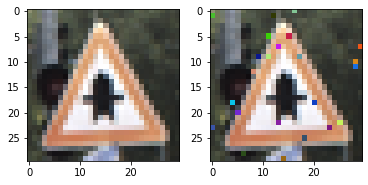

In [60]:
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img2)

In [61]:
seed = 4; n_pixel = 3
if seed != None:
    random.seed(seed)

x_coords = random.sample(range(0, 30), n_pixel)
y_coords = random.sample(range(0, 30), n_pixel)

points = np.array([x_coords,y_coords])

r_color = random.sample(range(0, 256), n_pixel)
g_color = random.sample(range(0, 256), n_pixel)
b_color = random.sample(range(0, 256), n_pixel)

In [62]:
print(x_coords)
print(y_coords)
print(r_color)
print(g_color)
print(b_color)

[7, 9, 3]
[23, 12, 15]
[79, 46, 34]
[10, 205, 148]
[30, 113, 184]


In [63]:
random.seed(4)
x_coords = random.sample(range(0, 30), n_pixel)
y_coords = random.sample(range(0, 30), n_pixel)

points = np.array([x_coords,y_coords])

r_color = random.sample(range(0, 256), n_pixel)
g_color = random.sample(range(0, 256), n_pixel)
b_color = random.sample(range(0, 256), n_pixel)

In [64]:
print(x_coords)
print(y_coords)
print(r_color)
print(g_color)
print(b_color)

[7, 9, 3]
[23, 12, 15]
[79, 46, 34]
[10, 205, 148]
[30, 113, 184]
